# ЛР 7 — ЧАСТОТНО-ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ ВРЕМЕННЫХ РЯДОВ

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy import signal
import scipy
%matplotlib inline

2. ВР с ЛЧМ (линейной частотной модуляцией) в диапазоне от 50 до 150 Гц:

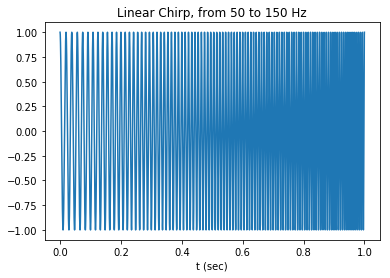

In [113]:
tx = np.linspace(0, 1, 8192) # временной отрезок от 0 до 1 сек
w = signal.chirp(tx, f0 = 50, f1 = 150, t1 = 1, method='linear')
# от 50 до 150 Гц за 1 секунду, ЛЧМ
plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.title("Linear Chirp, from 50 to 150 Hz")
plt.xlabel('t (sec)')
plt.show()

3. Построим спектрограмму заданного ряда, чтобы вычислить его
частотно-временные характеристики. Для этого сначала нам
потребуется рассчитать его частоту дискретизации:

In [114]:
fs = 1/(tx[1] - tx[0]) # fs = 1/dt = N/T

4. Строим спектрограмму по умолчанию:

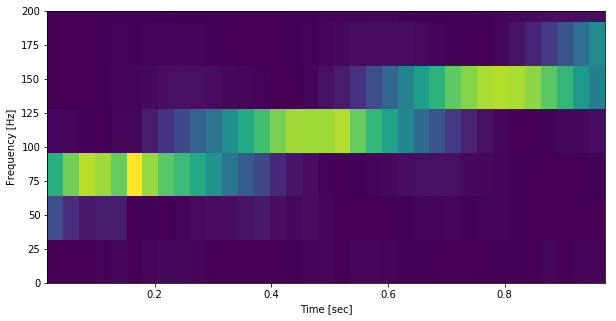

In [115]:
f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени
plt.figure(figsize = (16, 5))
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 200) # строим до 200 Гц, иначе будет до fs/2
plt.xlabel('Time [sec]')
plt.show()

5.  изменить параметры спектрограммы
для более ярко-выраженного результат

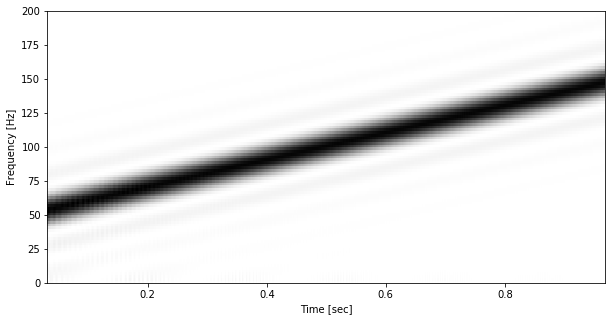

In [116]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096)
# длина каждого сегмента = 512, число пересекающихся точек между
#сегментами = 496, длина FFT = 4096
plt.figure(figsize = (16, 5))
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 200)
plt.xlabel('Time [sec]')
plt.show()

__Преобразование Гильберта__ позволяет однозначно определить понятие аналитического сигнала, через который можно определить и функцию амплитудной модуляции (АМ, мгновенная амплитуда), и функцию фазы, и функцию __мгновенной частоты__ (instantaneous frequency), как производную от мгновенной фазы, то есть как раз искомую зависимость частоты от времени для ЧМ.

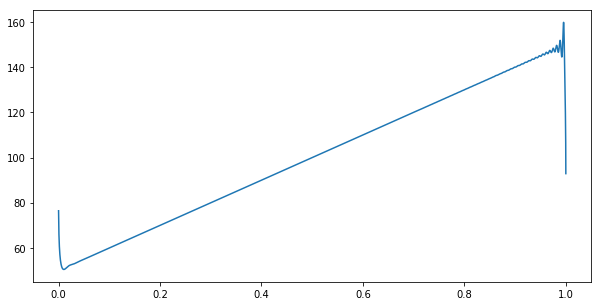

In [117]:
analytic_signal = signal.hilbert(w) # аналитический сигнал
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# мгновенная фаза в развернутом непрерывном виде

instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)
# мгновенная частота как производная от фазы, приведенная в Гц
plt.figure(figsize = (16, 5))

# из-за численного расчета производной массив мгновенной частоты
# будет меньше массива времени на одну точку:
plt.plot(tx[1:], instantaneous_frequency)
plt.show()

In [348]:
def func_f(t, b0, b1):
    return b0 + b1 * t

def f2(t, b0, b1, b2): 
    return b0 + b1 * t + b2 * t* t

def f3(t, b0, b1, b2, b3): 
    return b0 + b1 * t + b2 * t* t + b3 * t * t * t

def flog(t, b0, b1): 
    return  b0 + b1 *np.log(t)

def fexp(t, b0, b1): 
    return  np.log(b0)+ b1 * t

def func(t, b):
    return b[0] + b[1]*t 

def func2(t, b): 
    return b[0] + b[1]*t + b[2]*t*t 

def func3(t, b): 
    return b[0] + b[1]*t + b[2]*t*t +b[3]*t*t*t

def funclog(t, b): 
    return b[0] + b[1]*np.log(t)

def funcexp(t, b): 
    return b[0] * np.exp(b[1]*t)

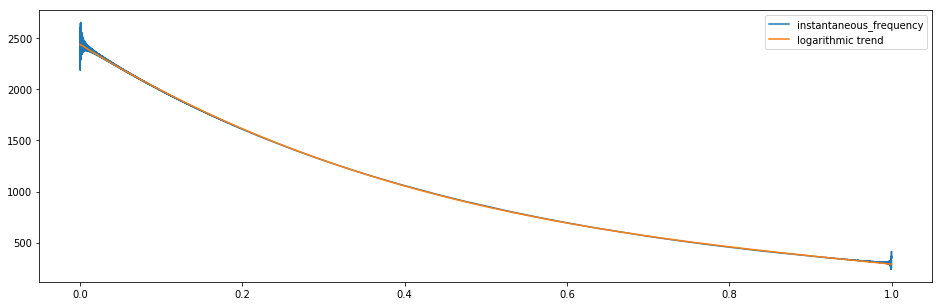

In [353]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'hyperbolic'), label='hyperbolic trend')
plt.legend()
plt.show()

In [342]:
from scipy.optimize import curve_fit

def trend(t, Y, tr = 'smooth', cut = 0, window_len = 25):
    """
    Построение тренда
    t - временное пространство
    Y - исходный ряд
    tr - режим (linear/quadratic/hyperbolic/logarithmic/exponential/smooth(default)
    cut - обрезка данных
    window_len - ширина окна сглаживания (только для режима smooth) 
    """
    if cut > 0:
            Y = Y[cut: -cut]
            t = t[cut: -cut]
            
    if tr == 'linear':
        B_lin_curve_fit, pcov = curve_fit(func_f, t, Y) # проводим подгонку МНК
#         print("curve fit params ", B_lin_curve_fit)
        return np.array(func(t, B_lin_curve_fit))
    
    elif tr == 'quadratic':
        B_quad_curve_fit, pcov = curve_fit(f2, t, Y) # проводим подгонку МНК
#         print("curve fit params ", B_quad_curve_fit)
        return np.array(func2(t, B_quad_curve_fit))
    
    elif tr == 'hyperbolic':
        B_cubic_curve_fit, pcov = curve_fit(f3, t, Y) # проводим подгонку МНК
#         print("curve fit params ", B_cubic_curve_fit)
        return np.array(func3(t, B_cubic_curve_fit))
    
    elif tr == 'logarithmic':
        B_log_curve_fit, pcov = curve_fit(flog, t, Y)
#         print("curve fit params ", B_log_curve_fit)
        return np.array(funclog(t, B_log_curve_fit))
    
    elif tr == 'exponential':
        B_exp_curve_fit, pcov = curve_fit(fexp, t, Y)
#         print("curve fit params ", B_exp_curve_fit)
        return np.array(funcexp(t, B_exp_curve_fit))
    else:
        #smooth

        half_window=window_len//2
        Y=np.concatenate([[Y[0]]*half_window, Y, [Y[-1]]*half_window])
        smoothed=[]
    
        for i in range(half_window,len(Y)-half_window):
            smoothed.append(Y[i-half_window:i+1+half_window].sum()/window_len)
        return np.array(smoothed)
    

8. постройте линейный тренд для мгновенной частоты
instantaneous_frequency по методу линейной регрессии и по методу
скользящего среднего сглаживания. Оцените диапазон частоты
(значение частоты в начальной и конечной точках) в обоих случаях.

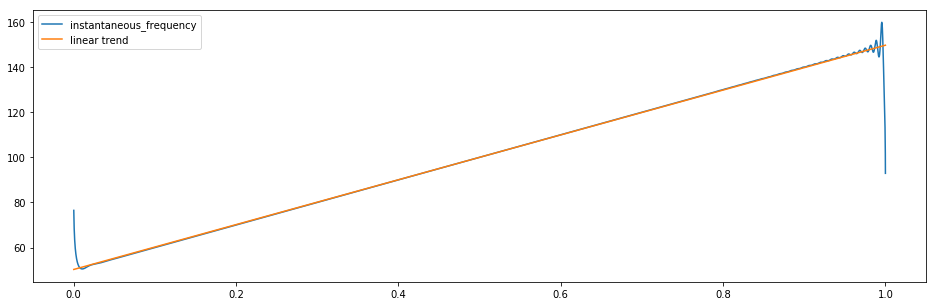

In [153]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'linear'), label='linear trend')
plt.legend()
plt.show()

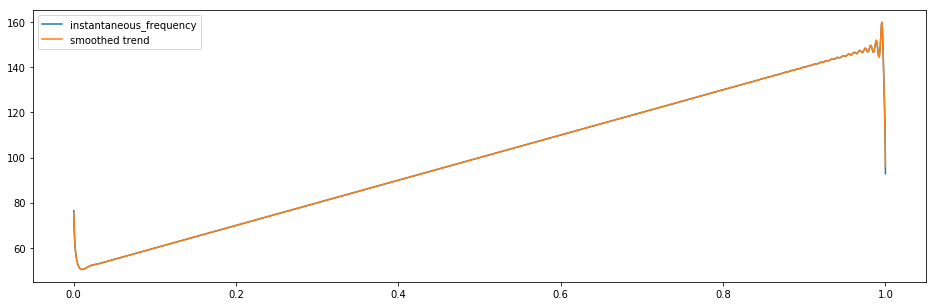

In [158]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, window_len=3), label='smoothed trend')
plt.legend()
plt.show()

9. постройте зависимость частоты от времени для следующих модельных временных рядов через спектрограмму и преобразование Гильберта, не забывая сглаживать мгновенную частоту регрессионной кривой

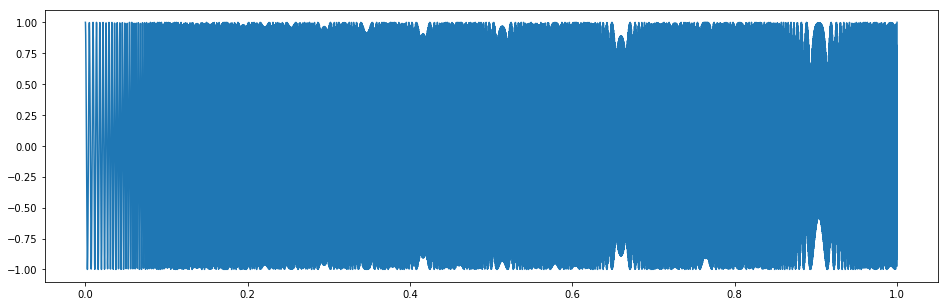

In [218]:
tx = np.linspace(0, 1, 8192) # ЛЧМ в большем диапазоне 
w = signal.chirp(tx, f0=200, f1=3000, t1=1, method='linear') 

plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.show()

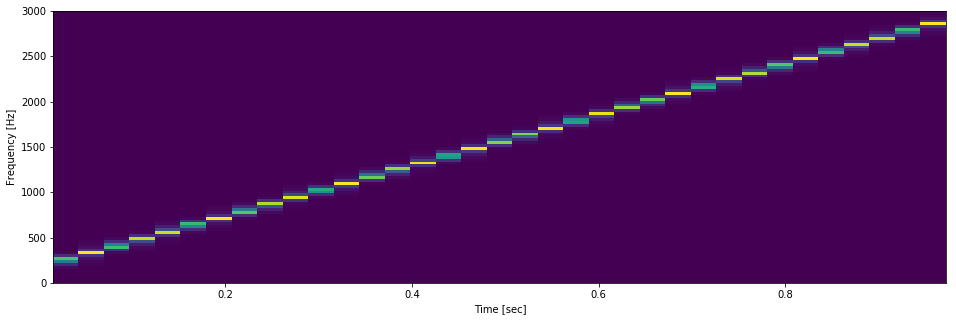

In [219]:
fs = 1/(tx[1]-tx[0]) 
f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 3000)
plt.xlabel('Time [sec]') 
plt.show()

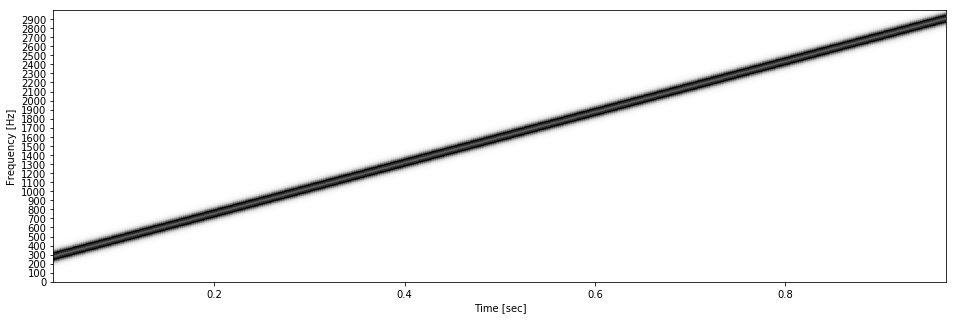

In [160]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 3000) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 3000, step=100))
plt.show() 

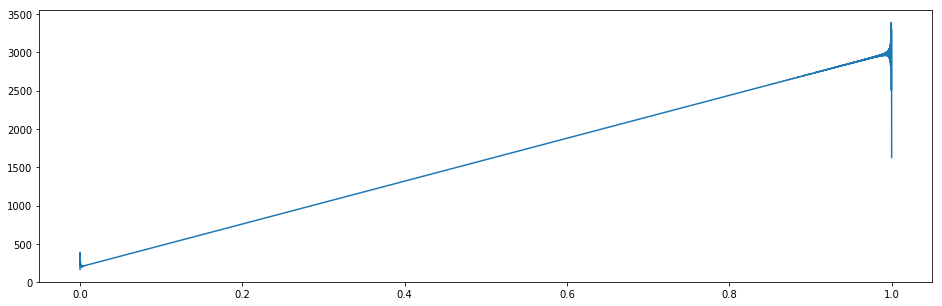

In [162]:
analytic_signal = signal.hilbert(w) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

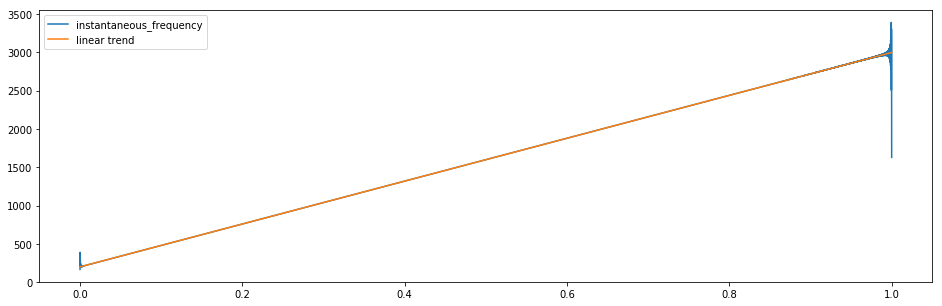

In [167]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'linear'), label='linear trend')
plt.legend()
plt.show()

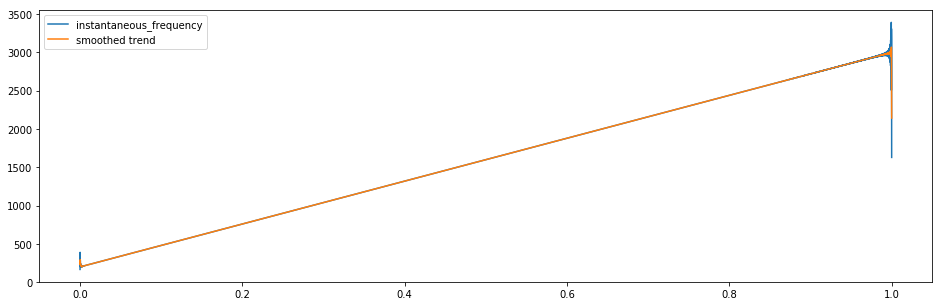

In [164]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, window_len=3), label='smoothed trend')
plt.legend()
plt.show()

10. Ряд с квадратичной частотной модуляцией

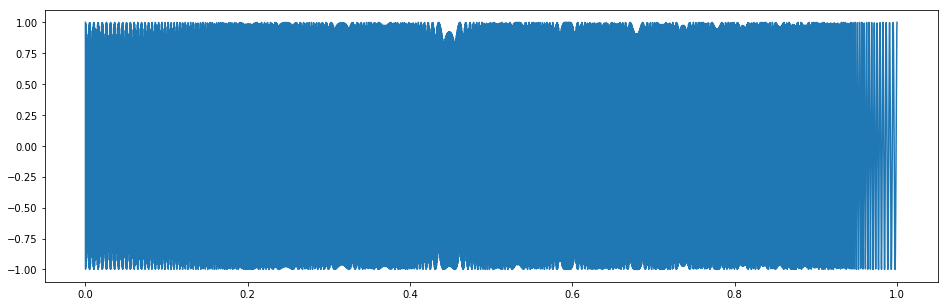

In [220]:
tx = np.linspace(0, 1, 8192)
w = signal.chirp(tx, f0=2000, f1=200, t1=1, method='quadratic')

plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.show()

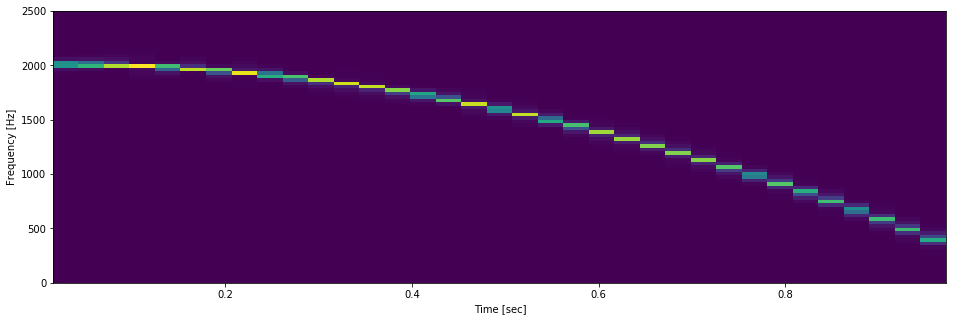

In [221]:
fs = 1/(tx[1]-tx[0]) 
f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 2500)
plt.xlabel('Time [sec]') 
plt.show()

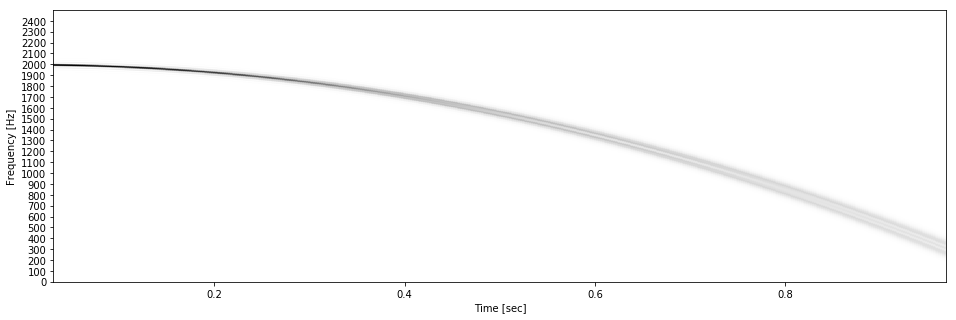

In [169]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 2500) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 2500, step=100))
plt.show() 

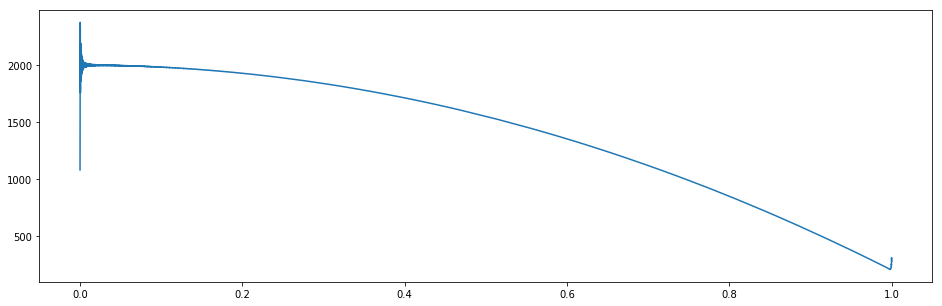

In [171]:
analytic_signal = signal.hilbert(w) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

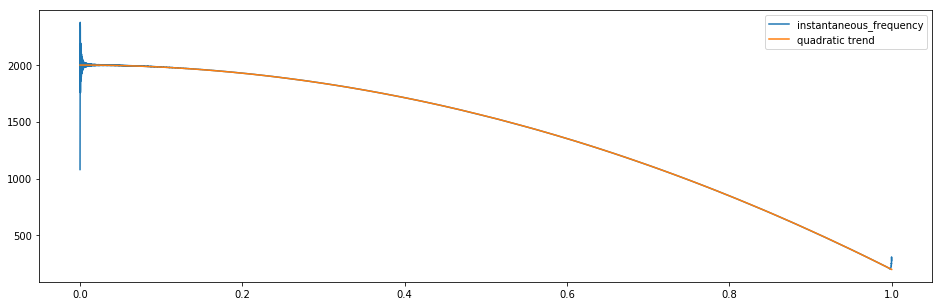

In [174]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'quadratic'), label='quadratic trend')
plt.legend()
plt.show()

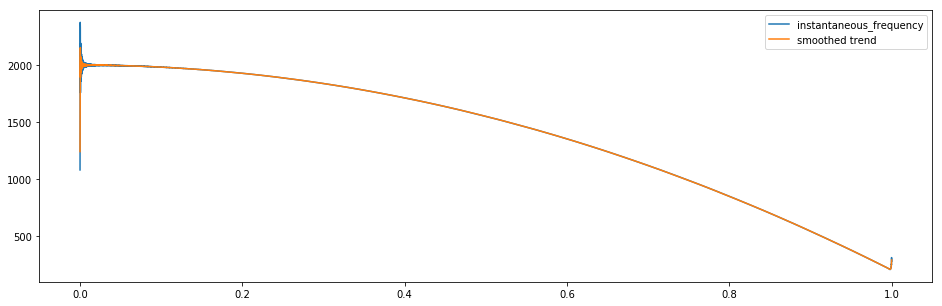

In [178]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, window_len=3), label='smoothed trend')
plt.legend()
plt.show()

11. Ряд с инверсной квадратичной частотной модуляцией:

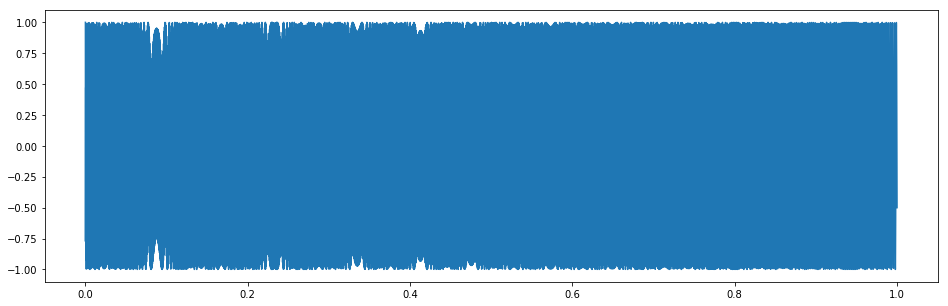

In [222]:
tx = np.linspace(0, 1, 8192) 
w = signal.chirp(tx, f0=3200, f1=400, t1=1, method='quadratic', vertex_zero=False) 

plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.show()

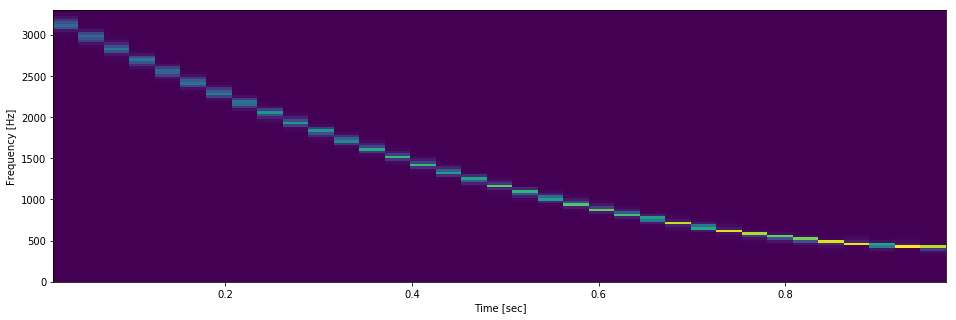

In [223]:
fs = 1/(tx[1]-tx[0]) 

f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 3300) 
plt.xlabel('Time [sec]') 
plt.show()

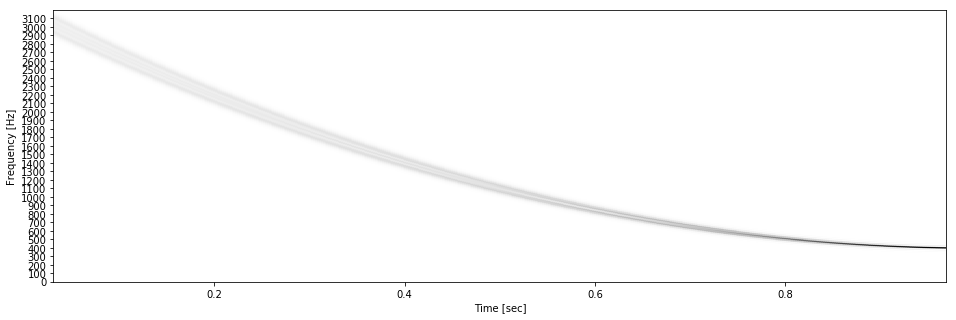

In [182]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16 , 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 3200) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 3200, step=100))
plt.show() 

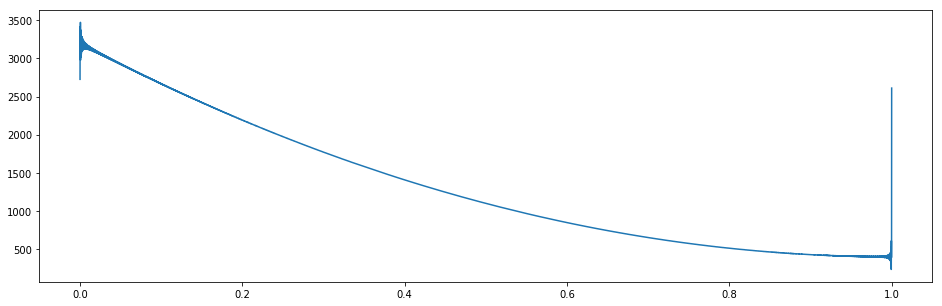

In [183]:
analytic_signal = signal.hilbert(w) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

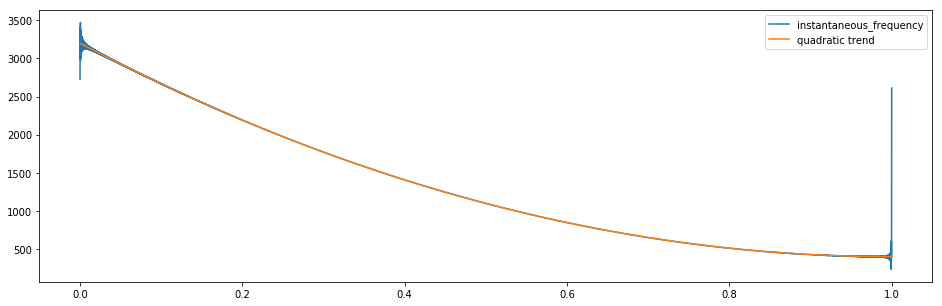

In [184]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'quadratic'), label='quadratic trend')
plt.legend()
plt.show()

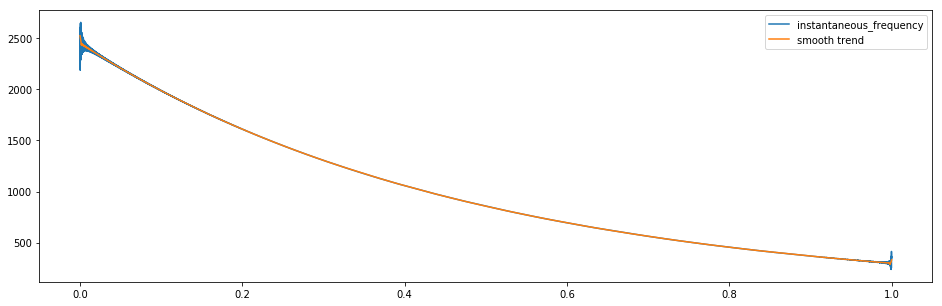

In [194]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'smooth'), label='smooth trend')
plt.legend()
plt.show()

12. Ряд с логарифмической частотной модуляцией:

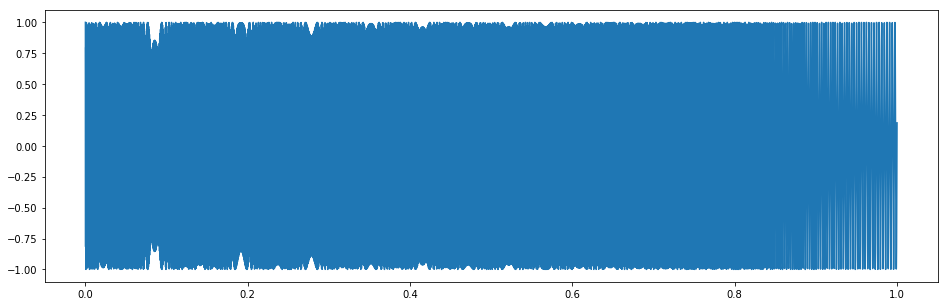

In [298]:
tx = np.linspace(0, 1, 8192) 
w = signal.chirp(tx, f0=2450, f1=300, t1=1, method='logarithmic') 

plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.show()

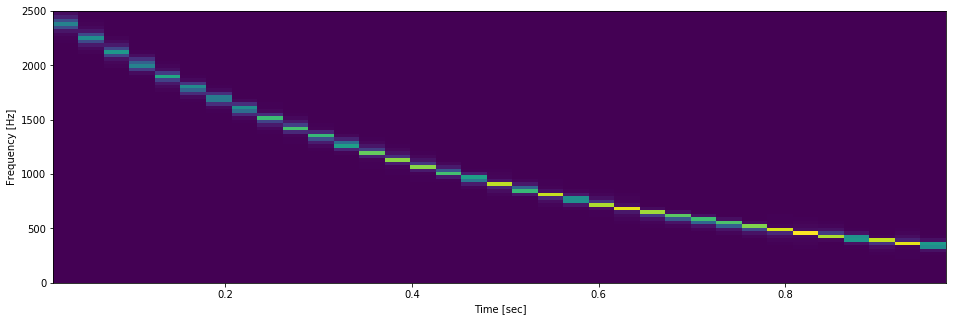

In [299]:
fs = 1/(tx[1]-tx[0]) 

f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 2500) 
plt.xlabel('Time [sec]') 
plt.show()

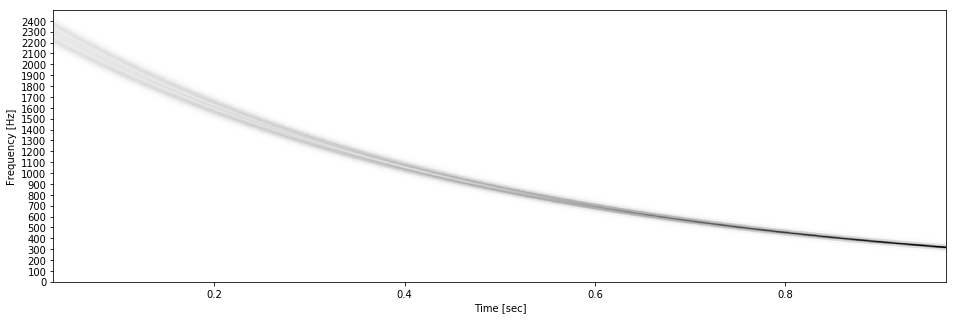

In [300]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 2500) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 2500, step=100))
plt.show() 

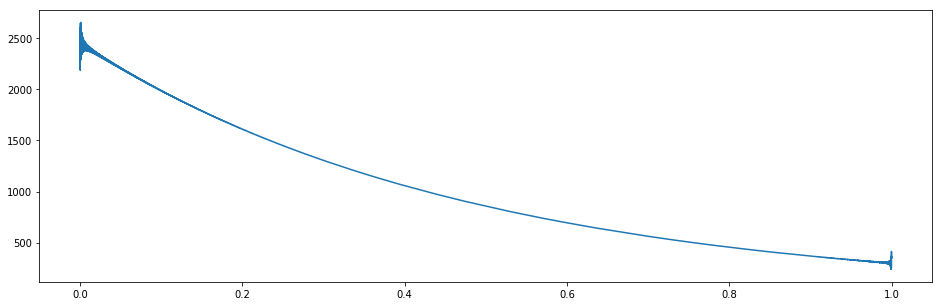

In [303]:
analytic_signal = signal.hilbert(w) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

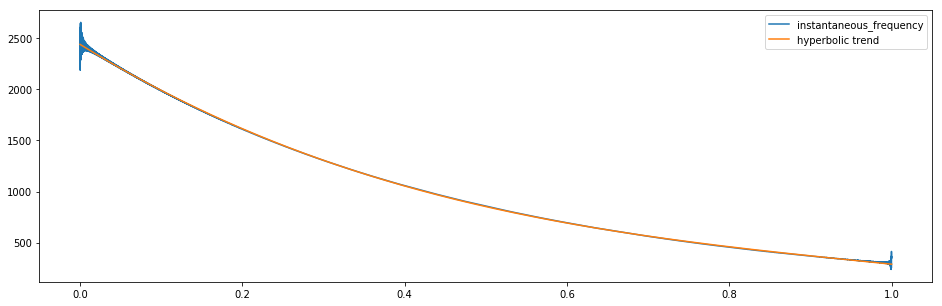

In [358]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'hyperbolic'), label='hyperbolic trend')
plt.legend()
plt.show()

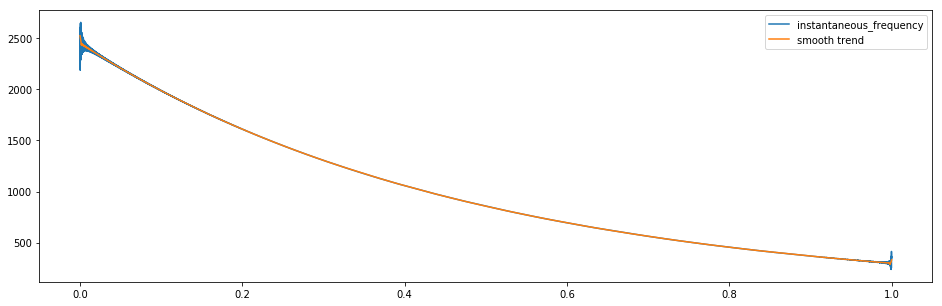

In [305]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'smooth'), label='smooth trend')
plt.legend()
plt.show()

13. Ряд с гиперболической частотной модуляцией:

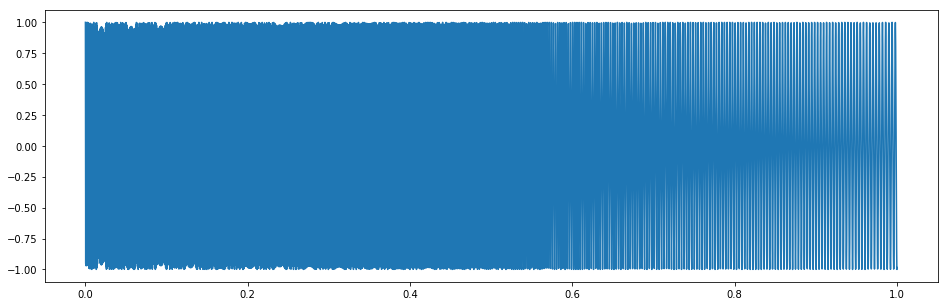

In [226]:
tx = np.linspace(0, 1, 8192) 
w = signal.chirp(tx, f0=1500, f1=250, t1=1, method='hyperbolic') 

plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.show()

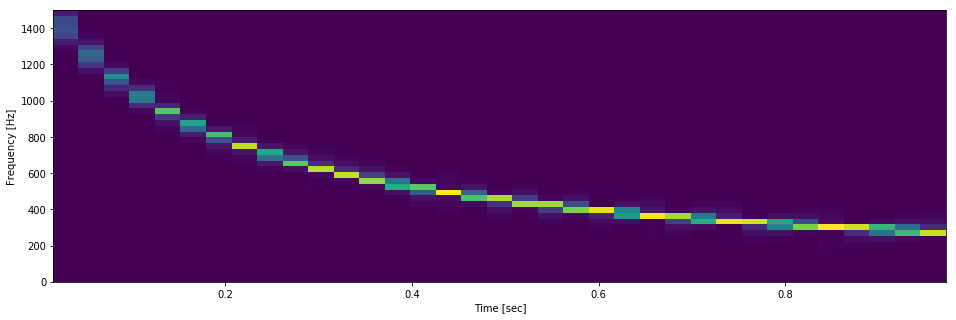

In [227]:
fs = 1/(tx[1]-tx[0]) 

f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 1500) 
plt.xlabel('Time [sec]') 
plt.show()

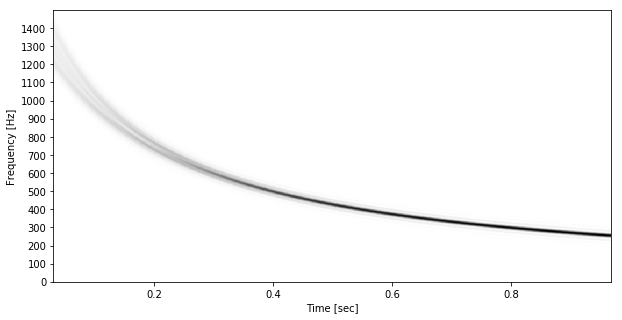

In [201]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (10, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 1500) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 1500, step=100))
plt.show() 

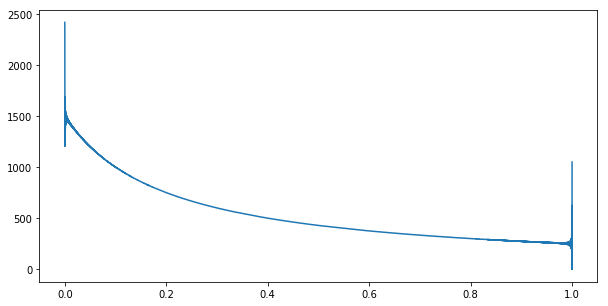

In [202]:
analytic_signal = signal.hilbert(w) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (10, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

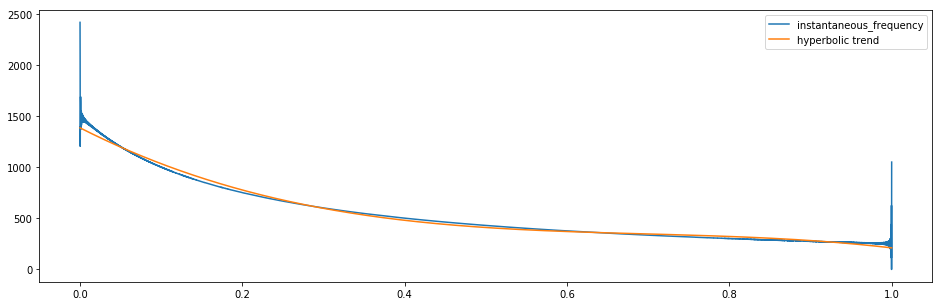

In [203]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'hyperbolic'), label='hyperbolic trend')
plt.legend()
plt.show()

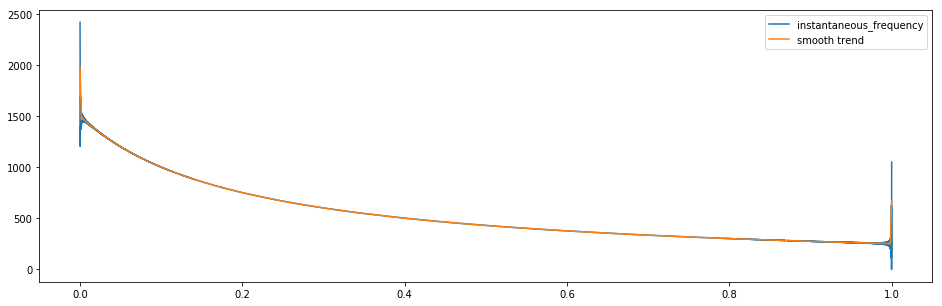

In [204]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'smooth'), label='smooth trend')
plt.legend()
plt.show()

14. Ряд с полиномиальной частотной модуляцией:

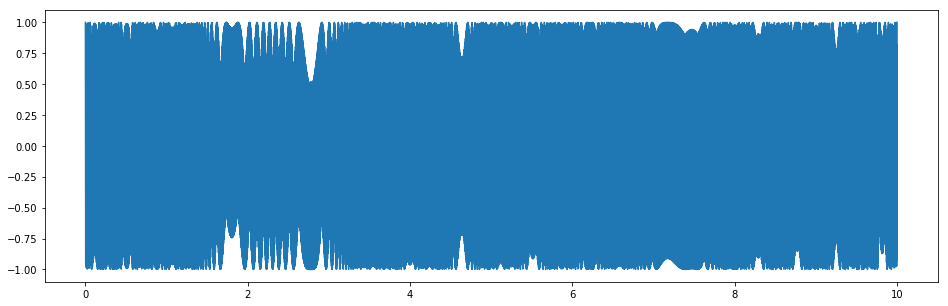

In [228]:
tx = np.linspace(0, 10, 8192)
p = np.poly1d([2.5, -36.0, 125.0, 150.0]) 
w = signal.sweep_poly(tx, p)

plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.show()

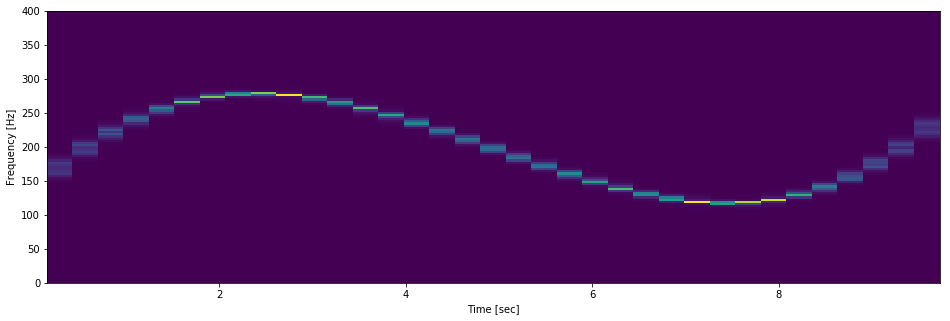

In [229]:
fs = 1/(tx[1]-tx[0]) 

f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 400) 
plt.xlabel('Time [sec]') 
plt.show()

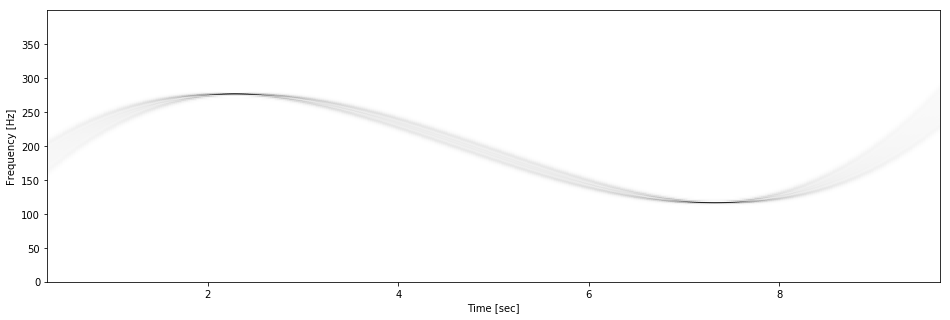

In [207]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 400) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 400, step=50))
plt.show() 

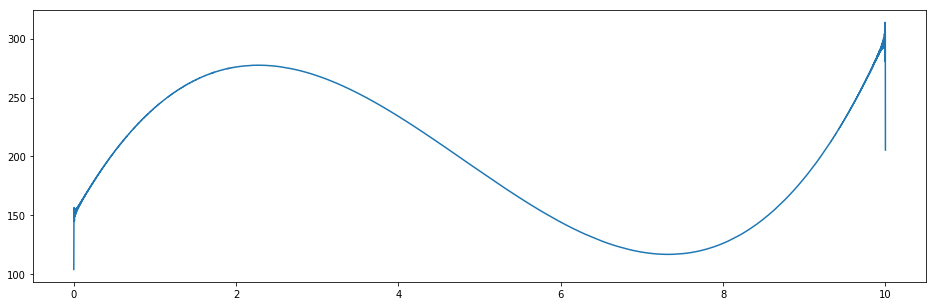

In [208]:
analytic_signal = signal.hilbert(w) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

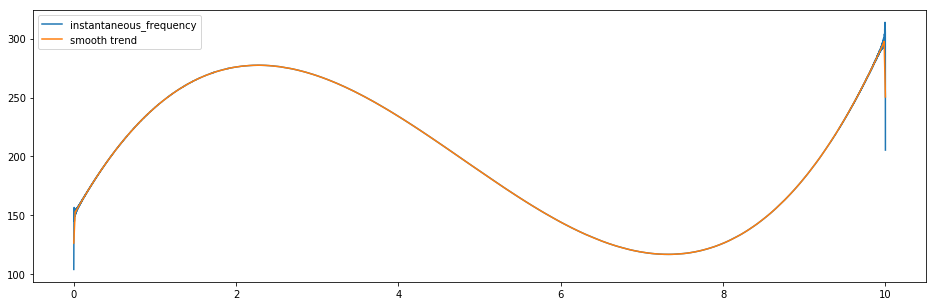

In [209]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'smooth'), label='smooth trend')
plt.legend()
plt.show()

16. Ряд с частотной модуляцией другим гармоническим сигналом:

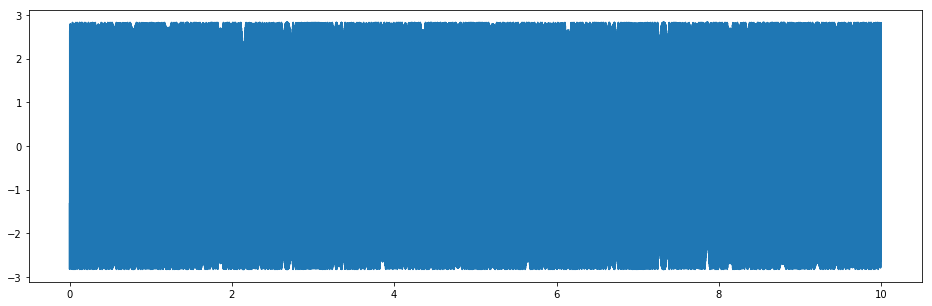

In [230]:
tx = np.linspace(0, 10, 2*8192) 
mod = 500*np.cos(2*np.pi*0.25*tx) 
w = 2 * np.sqrt(2) * np.sin(2*np.pi*300*tx + mod) 

plt.figure(figsize = (16, 5))
plt.plot(tx, w)
plt.show()

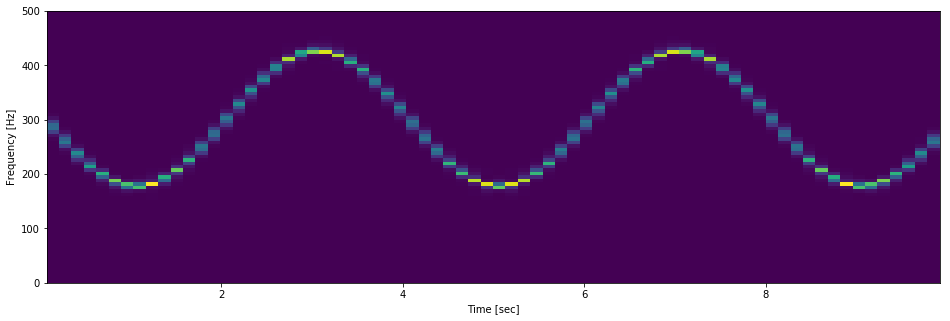

In [231]:
fs = 1/(tx[1]-tx[0]) 

f, t, Sxx = signal.spectrogram(w, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 500) 
plt.xlabel('Time [sec]') 
plt.show()

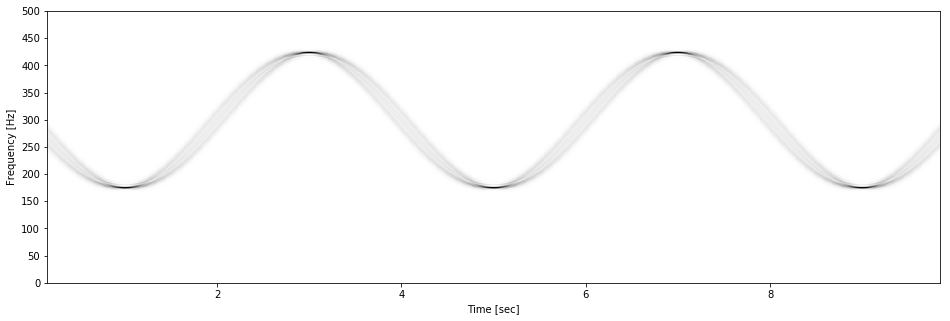

In [211]:
f, t, Sxx = signal.spectrogram(w, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 500) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 550, step=50))
plt.show() 

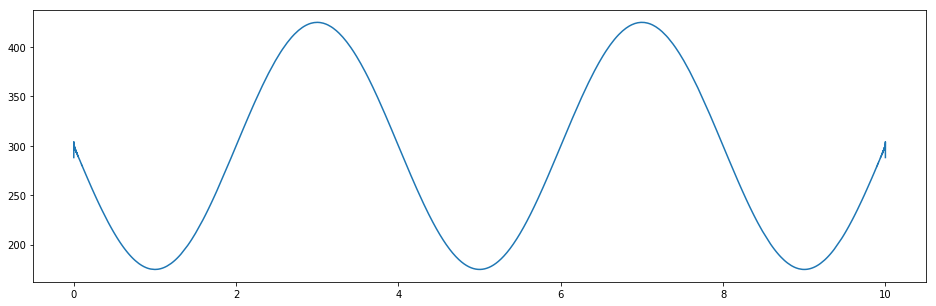

In [212]:
analytic_signal = signal.hilbert(w) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

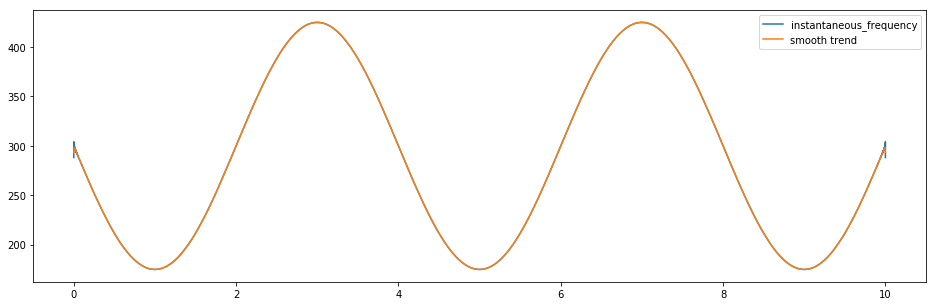

In [213]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'smooth'), label='smooth trend')
plt.legend()
plt.show()

16. Ряд с частотным изломом:

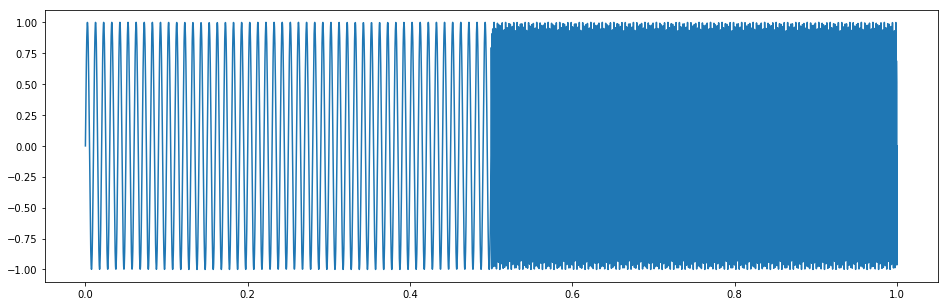

In [234]:
tx = np.linspace(0, 1, 4096) 
xf = np.zeros(4096) 
for i in range(0, len(tx)//2):
    xf[i] = np.sin(2*np.pi*100*tx[i])     
for i in range(len(tx)//2, len(tx)):
    xf[i] = np.sin(2*np.pi*1200*tx[i]) 

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

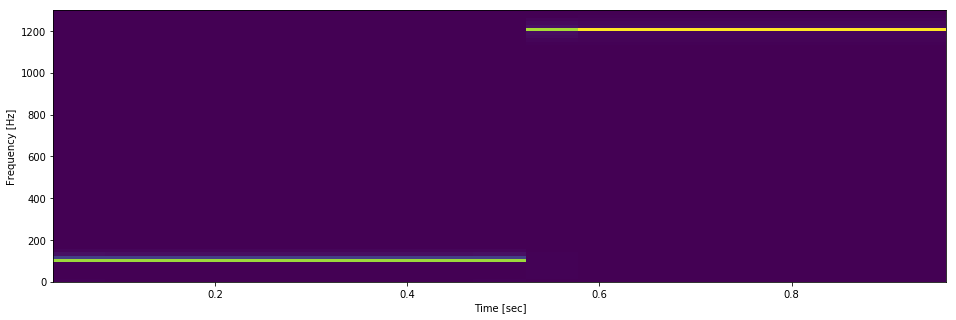

In [233]:
fs = 1/(tx[1]-tx[0]) 

f, t, Sxx = signal.spectrogram(xf, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 1300) 
plt.xlabel('Time [sec]') 
plt.show()

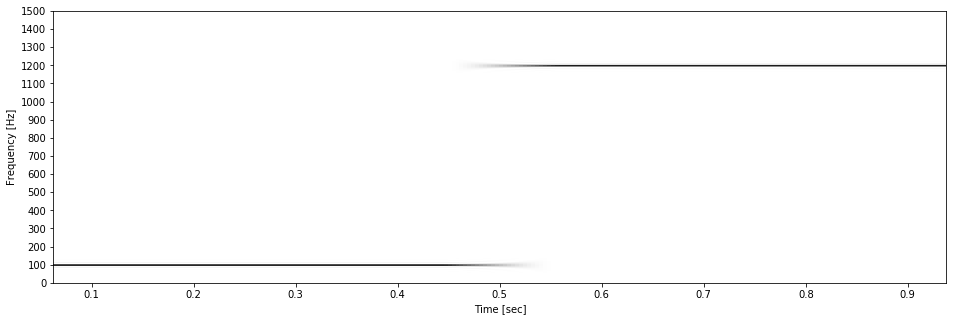

In [215]:
f, t, Sxx = signal.spectrogram(xf, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 1500) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 1600, step=100))
plt.show() 

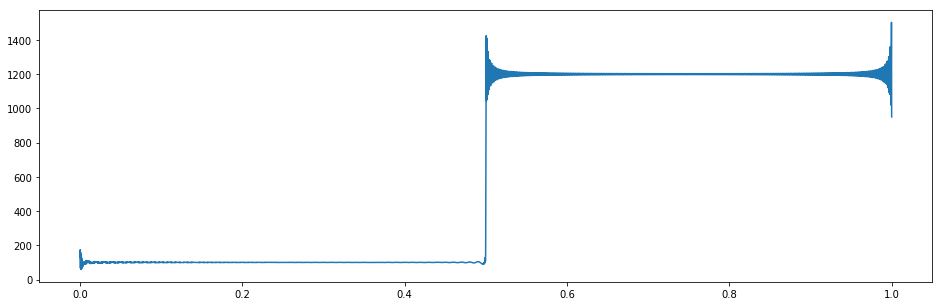

In [216]:
analytic_signal = signal.hilbert(xf) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

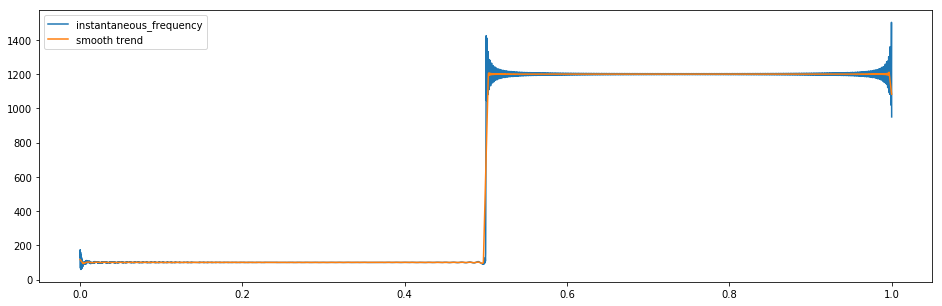

In [217]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'smooth'), label='smooth trend')
plt.legend()
plt.show()

17. Временной ряд из 4 гармоник без шума:

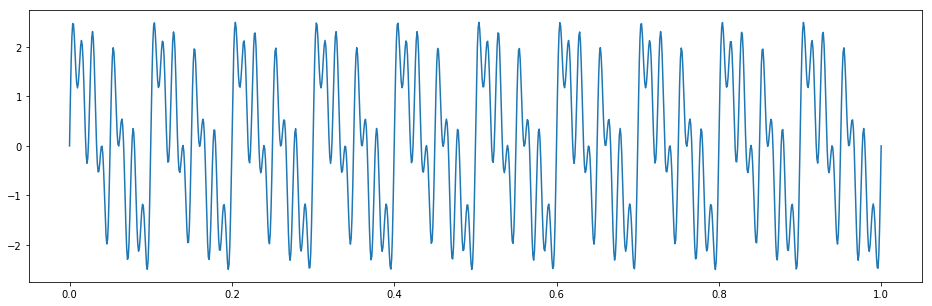

In [236]:
tx = np.linspace(0, 1, 1024) 
f1 = 10 
f2 = 20 
f3 = 40
f4 = 80
xf = np.sin(2 * np.pi * f1 * tx) + np.sin(2 * np.pi * f2 * tx) \
    + np.sin(2 * np.pi * f3 * tx) + np.sin(2 * np.pi * f4 * tx)

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

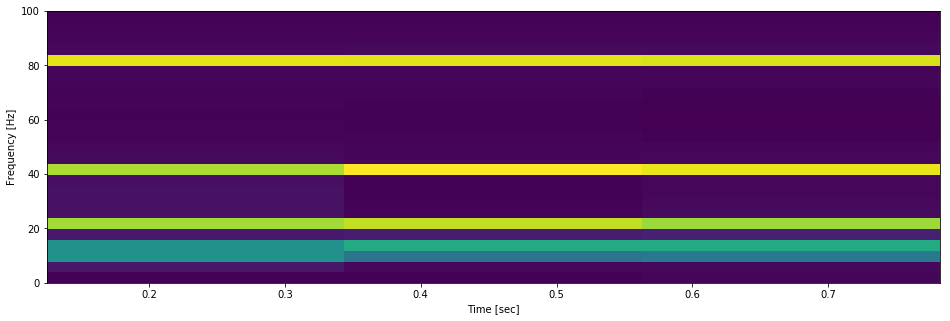

In [242]:
fs = 1/(tx[1]-tx[0]) 

f, t, Sxx = signal.spectrogram(xf, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 100) 
plt.xlabel('Time [sec]') 
plt.show()

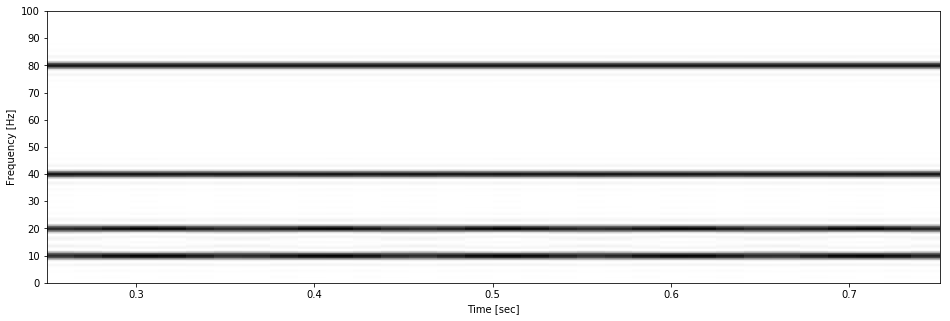

In [243]:
f, t, Sxx = signal.spectrogram(xf, fs, nperseg = 512, noverlap = 496, nfft=4096) 
# длина каждого сегмента = 512, число пересекающихся точек между сегментами = 496, длина FFT = 4096 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(t, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 100) 
plt.xlabel('Time [sec]') 
plt.yticks(np.arange(0, 110, step=10))
plt.show() 

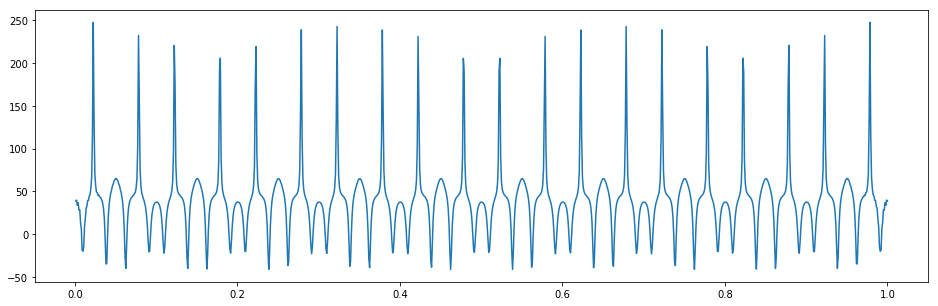

In [244]:
analytic_signal = signal.hilbert(xf) # аналитический сигнал 
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) 
# мгновенная фаза в развернутом непрерывном виде 
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) 
# мгновенная частота как производная от фазы, приведенная в Гц 
plt.figure(figsize = (16, 5)) 
# из-за численного расчета производной массив мгновенной частоты будет меньше массива времени на одну точку: 
plt.plot(tx[1:], instantaneous_frequency)  
plt.show()

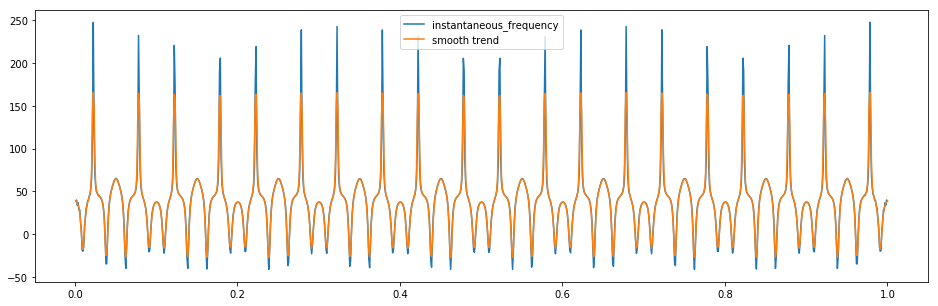

In [241]:
plt.figure(figsize = (16, 5))
plt.plot(tx[1:], instantaneous_frequency, label='instantaneous_frequency')
plt.plot(tx[1:], trend(tx[1:], instantaneous_frequency, 'smooth', window_len=3), label='smooth trend')
plt.legend()
plt.show()

20. реализовать базовый метод Эмпирической Модовой Декомпозиции (ЭМД) в Python

In [381]:
def emd_custom(u, mods = 0):
    import math
    import scipy.signal
    import scipy.interpolate
    from scipy.signal import argrelextrema 
    from scipy.interpolate import CubicSpline
    N = len(u)
    if mods == 0:
        mods = int(math.log(N, 2))
    t = range(N)
    u = np.array(u)
    c = []
    for i in range(mods):
        uj = u
        for j in range(10):
            
            #max
            max_inds = argrelextrema(uj, np.greater)[0]
            max_vals = [uj[i] for i in max_inds] 
            U = CubicSpline(max_inds, max_vals)
            
            #min
            min_inds = argrelextrema(uj, np.less)[0]
            min_vals = [uj[i] for i in min_inds]
            L = CubicSpline(min_inds, min_vals)
            
            #mean
            m = (U(t) + L(t))/2
            r = uj - m
            
            uj = r
            
        c.append(r)
        u = u - r
    c.append(u)
    return c

In [364]:
import scipy as sp
from scipy import signal

def emd(x, n_components = 1):
    r = x
    t = np.arange(len(r))
    components = np.zeros(n_components, dtype=object)
    for i in range(n_components):
        r_tmp = r
        for j in range(10):
            up_dots = scipy.signal.argrelmax(r_tmp)[0]
            low_dots = scipy.signal.argrelmin(r_tmp)[0]
            
            up_dots_r = r_tmp[up_dots]
            fip = scipy.interpolate.CubicSpline(up_dots,up_dots_r)
            up_dots_t = fip(t)

            low_dots_r = r_tmp[low_dots]
            fitr = scipy.interpolate.CubicSpline(low_dots,low_dots_r)
            low_dots_t = fitr(t)

            mean_t = (up_dots_t + low_dots_t) / 2
            
            samp_start = np.max((np.min(up_dots),np.min(low_dots)))
            samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
            mean_t[:samp_start] = mean_t[samp_start]
            mean_t[samp_end:] = mean_t[samp_end]
            
            r_tmp = r_tmp - mean_t
        
        components[i] = r_tmp
        r = r - components[i] 
    
    return components

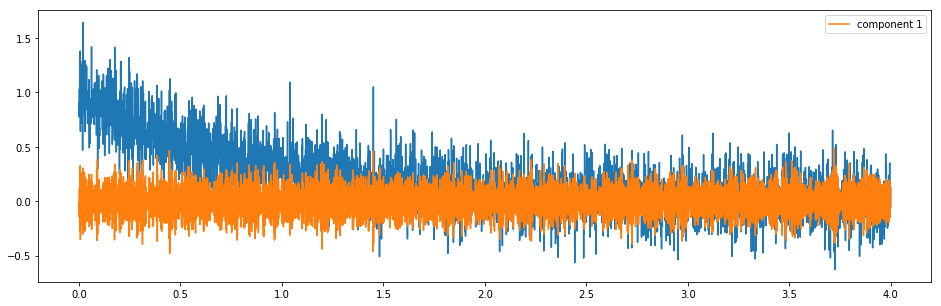

In [365]:
emd_results = emd(xf,1)

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.plot(tx, emd_results[0], label='component 1')
plt.legend()
plt.show()

25. Полученную реализацию ЭМД сначала апробируйте на самом простом модельном временном ряде – сумме двух периодик без шума

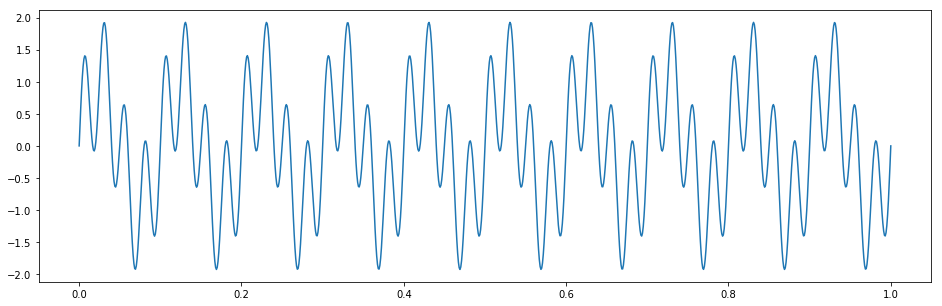

In [247]:
tx = np.linspace(0, 1, 1024) 
f1 = 10
f2 = 40 
xf = np.sin(2 * np.pi * f1 * tx) + np.sin(2 * np.pi * f2 * tx) 

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

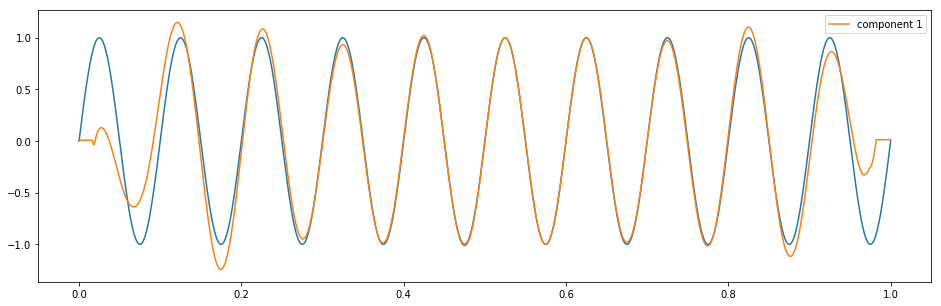

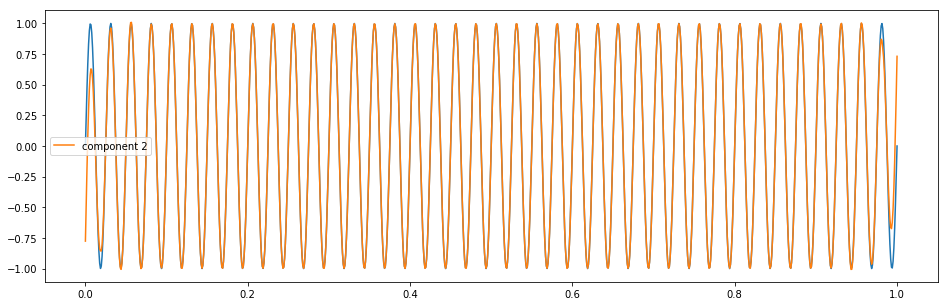

In [271]:
emd_results = emd(xf,2)

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f1 * tx))
plt.plot(tx, emd_results[1], label='component 1')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f2 * tx))
plt.plot(tx, emd_results[0], label='component 2')
plt.legend()
plt.show()

26. Затем готовый метод ЭМД примените к ряду, состоящему из 4 гармоник без шума (см. пункт 17),

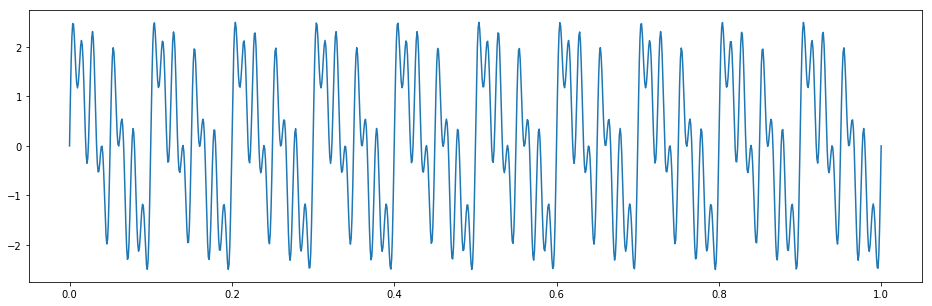

In [272]:
tx = np.linspace(0, 1, 1024) 
f1 = 10 
f2 = 20 
f3 = 40
f4 = 80
xf = np.sin(2 * np.pi * f1 * tx) + np.sin(2 * np.pi * f2 * tx) \
    + np.sin(2 * np.pi * f3 * tx) + np.sin(2 * np.pi * f4 * tx)

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

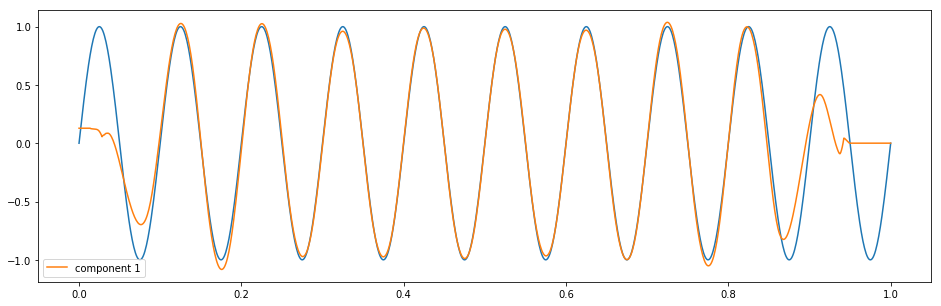

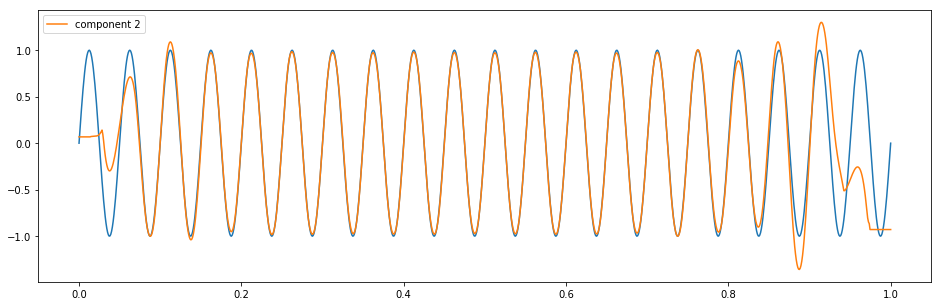

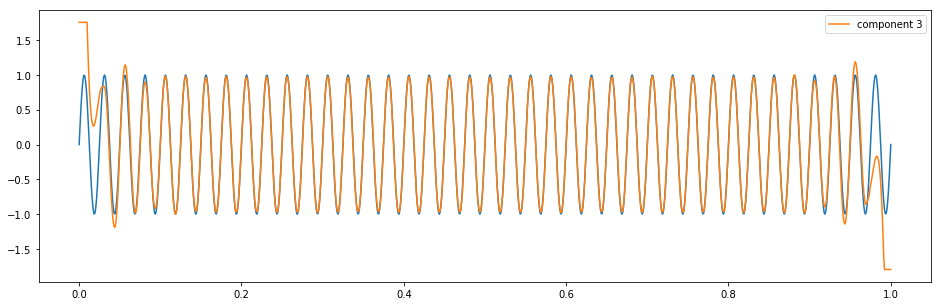

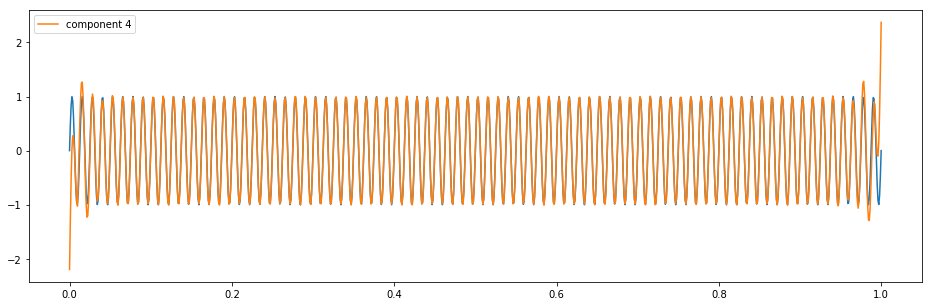

In [274]:
emd_results = emd(xf,4)

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f1 * tx))
plt.plot(tx, emd_results[3], label='component 1')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f2 * tx))
plt.plot(tx, emd_results[2], label='component 2')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f3 * tx))
plt.plot(tx, emd_results[1], label='component 3')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f4 * tx))
plt.plot(tx, emd_results[0], label='component 4')
plt.legend()
plt.show()

27. Затем добавьте в модельный ряд шум и посмотрите, как изменятся результаты.

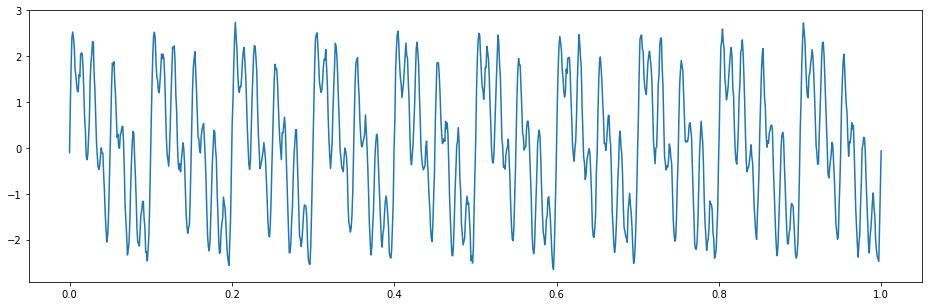

In [277]:
tx = np.linspace(0, 1, 1024) 
f1 = 10 
f2 = 20 
f3 = 40
f4 = 80
xf = np.sin(2 * np.pi * f1 * tx) + np.sin(2 * np.pi * f2 * tx) \
    + np.sin(2 * np.pi * f3 * tx) + np.sin(2 * np.pi * f4 * tx) + 0.1 * rand.randn(len(tx))

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

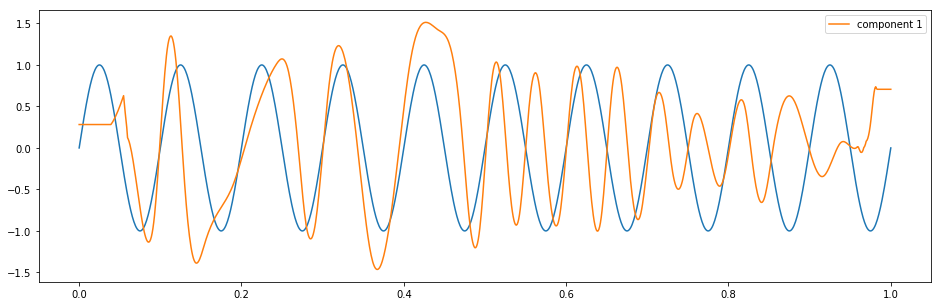

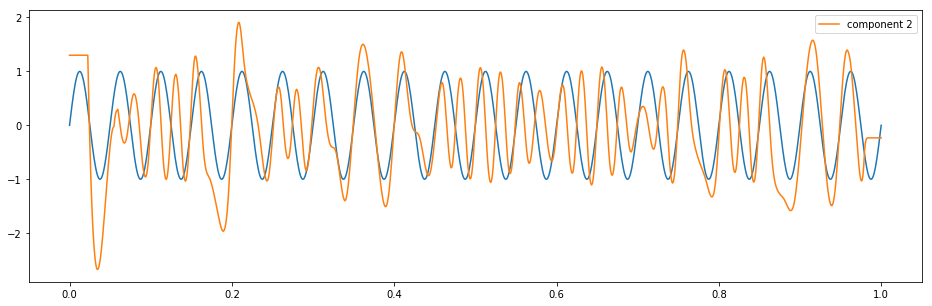

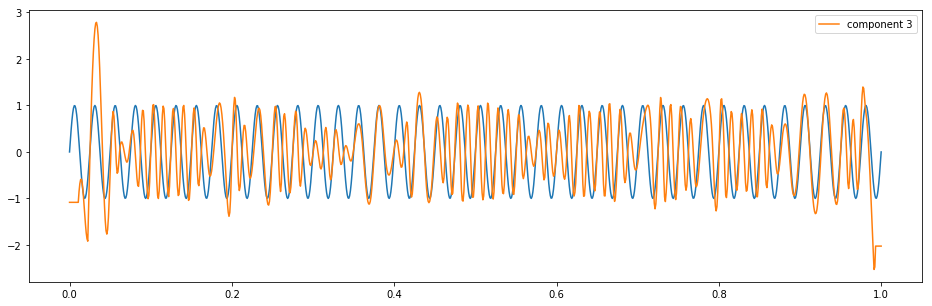

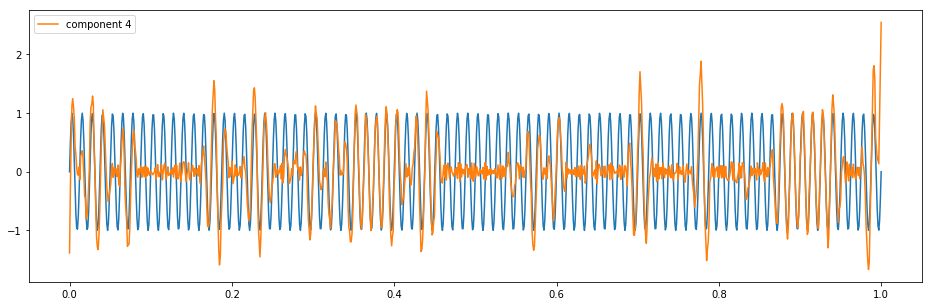

In [278]:
emd_results = emd(xf,4)

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f1 * tx))
plt.plot(tx, emd_results[3], label='component 1')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f2 * tx))
plt.plot(tx, emd_results[2], label='component 2')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f3 * tx))
plt.plot(tx, emd_results[1], label='component 3')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(tx, np.sin(2 * np.pi * f4 * tx))
plt.plot(tx, emd_results[0], label='component 4')
plt.legend()
plt.show()

28. Аналогично, попробуйте провести декомпозицию следующих временных рядов: с изломом частоты (см. пункт 16), случайный ряд белого шума с нормальным распределением, экспоненциальный зашумленный тренд:

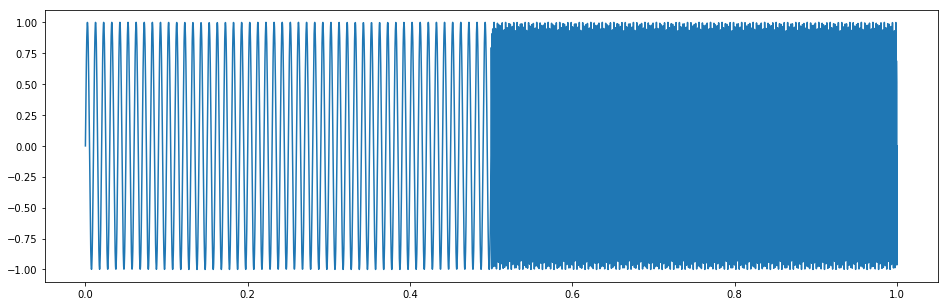

In [279]:
tx = np.linspace(0, 1, 4096) 
xf = np.zeros(4096) 
for i in range(0, len(tx)//2): 
    xf[i] = np.sin(2*np.pi*100*tx[i])     
for i in range(len(tx)//2, len(tx)): 
    xf[i] = np.sin(2*np.pi*1200*tx[i])
    
plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

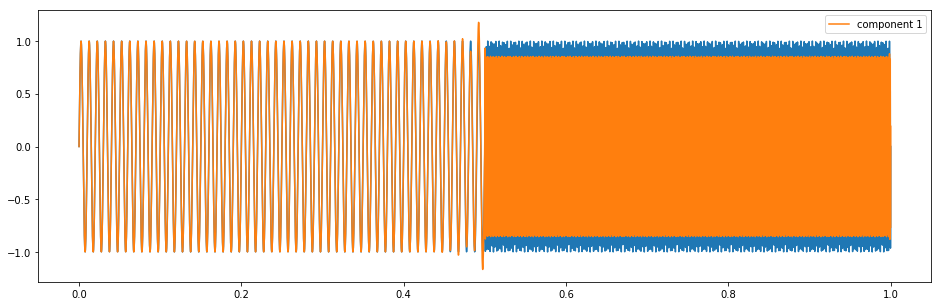

In [292]:
emd_results = emd(xf,1)

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.plot(tx, emd_results[0], label='component 1')
plt.legend()
plt.show()

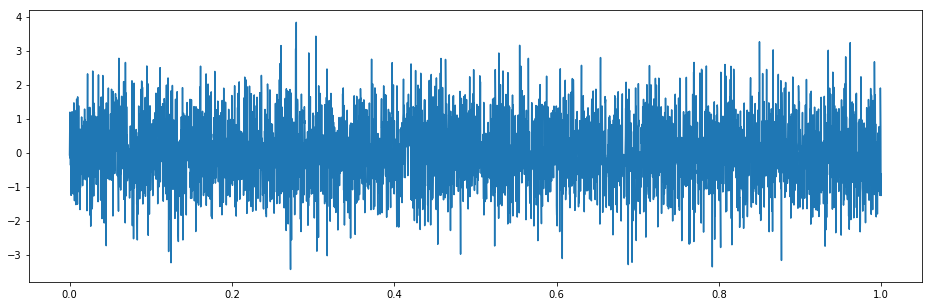

In [293]:
tx = np.linspace(0, 1, 4096)
xf = np.random.normal(0, 1, size=4096)

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

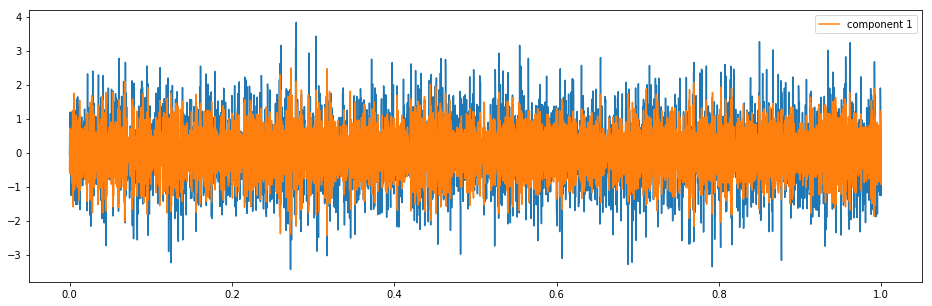

In [294]:
emd_results = emd(xf,1)

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.plot(tx, emd_results[0], label='component 1')
plt.legend()
plt.show()

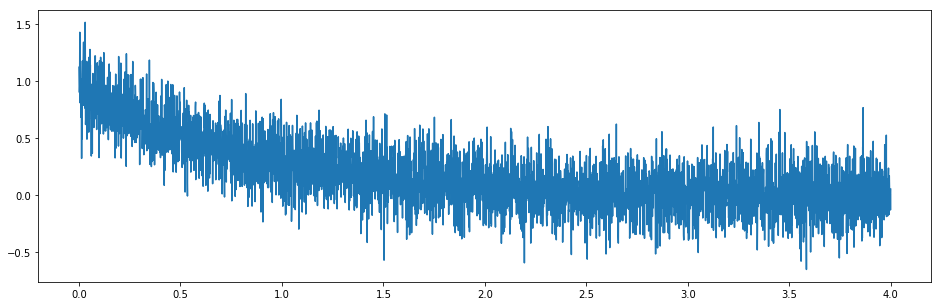

In [367]:
tx = np.linspace(0, 4, 4096)
xf = np.exp(-0.4*np.pi*tx) + 0.2*rand.randn(len(tx)) 

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.show()

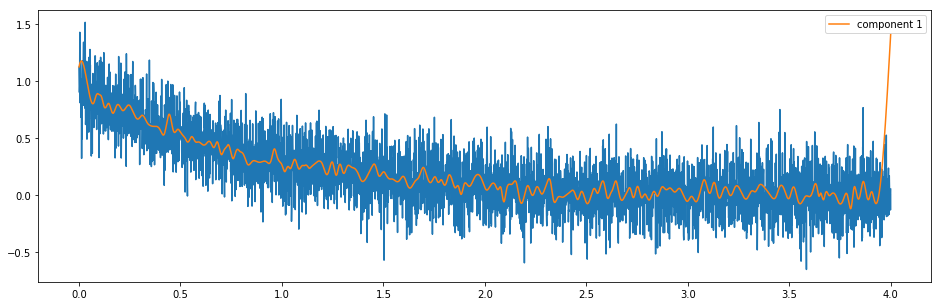

In [380]:
emd_results = emd_custom(xf,4)

plt.figure(figsize = (16, 5))
plt.plot(tx, xf)
plt.plot(tx, emd_results[4], label='component 1')
plt.legend()
plt.show()